# Non linear feature extraction from single cell RNAseq datasets using deep neural network. 
<b>Author</b>: GHEZAIEL Morad<br>
<b>Education</b>: M.sc 1 Immunology, M.sc 2 Bioinformatics (Software development & data analysis)<br>
<b>Date:</b> 09/11/2020<br>

## Introduction: 
This notebook is about demonstrating the use of deep learning to get biological insights from gene expression data. 
We will take advantage of the mouse blood sample single cell dataset from the following paper:

<u>A single-cell resolution map of mouse hematopoietic stem and progenitor cell differentiation
Sonia Nestorowa 1, Fiona K Hamey 1, Blanca Pijuan Sala 1, Evangelia Diamanti 1, Mairi Shepherd 1, Elisa Laurenti 1, Nicola K Wilson 1, David G Kent 1, Berthold Göttgens</u>

It consists in rougly 1500 cells for 4000 filtered barcodes.<br>

Importantly, no prior feature selection was performed.<br>

The notebook is provided with snippets that could be reused or intergrated in more conventional analysis pipelines. 



## Libraries

In [41]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
import umap
import collections
import re
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from keras.layers import Input, Dense, Dropout, LSTM
from keras.models import Model 
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import tensorflow as tf

### Data loading, processing and clustering
<b>Below is a python class that allows to:</b> 
- Compute counts distribution 
- Perform hierarchical clustering
- Perform scaling 
- Perform dimensionality reduction using UMAP and PCA

In [42]:
class init(): 
    
    def __init__(self,datapath,labelpath): 
        
        self.data =  pd.read_csv(datapath, sep=' ',  )
        self.labels = pd.read_csv(labelpath, sep=' ')
        print("N_cells = {}\nN_features = {}".format(self.data.shape[0],self.data.shape[1]))

    def getHists(self):
        
        plt.style.use('ggplot')
        f = plt.figure(figsize=(15,10))
        ax,ax1 = f.add_subplot(211),f.add_subplot(212)
        
        n_cells = np.arange(self.data.shape[0])
        n_genes = np.arange(self.data.shape[1])
        
        self.feature_counts = sorted(self.data.sum(axis=0)) 
        self.cell_counts = sorted(self.data.sum(axis=1))
        
        ax.bar(n_cells,self.cell_counts)
        ax1.bar(n_genes,self.feature_counts)
        ax.set_title("Cell counts")
        ax1.set_title("Features counts")
        
 
    def getPopulationDensity(self):
        
        dic = {self.labels.index[i]:self.labels["celltype"][i] for i in range(self.labels.shape[0])}
        
        self.labels = pd.DataFrame()
        self.labels["celltype"] = [dic[i] if i in dic else "Unknown" for i in self.data.index]
        self.labels["category"] = [self.data.index[i].split("_")[0] for i in range(len(self.data.index))]

        counts_ct = collections.Counter(self.labels["celltype"])
        counts_cat = collections.Counter(self.labels["category"])
        
        self.cell_density = [counts_ct[i] for i in counts_ct if i!="Unknown"]
        self.group_density = [counts_cat[i] for i in counts_cat]
        
        f = plt.figure(figsize=(10,10))
        cmap = plt.cm.get_cmap('RdYlBu_r')
  
        ax,ax1 = f.add_subplot(211),f.add_subplot(212)
        ax.bar(np.arange(len(self.cell_density)),self.cell_density,alpha=0.5)
        ax.set_xticks(np.arange(len(self.cell_density)))
        ax.set_xticklabels([i for i in counts_ct if i!="Unknown"])
        ax.set_title("Cell type distribution")
        
        ax1.bar(np.arange(len(self.group_density)),self.group_density,alpha=0.7)
        ax1.set_xticks(np.arange(len(self.group_density)))
        ax1.set_xticklabels([i for i in counts_cat])
        ax1.set_title("Cell group distribution")
        
        
    def getHC(self):
        
        linked = linkage(self.data,method="single")
        group_colors = ["lightblue","green","yellow"]
        group_colors = {np.unique(self.labels["category"])[idx]:group_colors[idx] for idx in range(len(group_colors))}
        group_colors = [group_colors[self.labels["category"][i]] for i in range(len(self.labels["category"]))]
        ax = sns.clustermap(linked,row_colors=group_colors,dendrogram_ratio=(.1, .2))
        
    def scaleData(self): 
        
        self.X = self.data.copy()
        sc = StandardScaler()
        self.X_scaled = sc.fit_transform(self.X)
        
    def getUMAP(self):
        
        raw_components = pd.DataFrame(umap.UMAP().fit_transform(self.X))
        scaled_components = pd.DataFrame(umap.UMAP().fit_transform(self.X_scaled))
        
        f = plt.figure(figsize=(15,10))
        ax,ax1 = f.add_subplot(121),f.add_subplot(122)
        sns.scatterplot(x = raw_components[0], y = raw_components[1],hue=self.labels["category"],ax=ax)
        sns.scatterplot(x = scaled_components[0], y = scaled_components[1],hue=self.labels["category"],ax=ax1)
        
        silhouette_raw = silhouette_score(raw_components, self.labels["category"])
        silhouette_scaled = silhouette_score(scaled_components, self.labels["category"])
        
        ax.set_title("Unscaled\nSilhouette = {}".format(round(silhouette_raw,2)))
        ax1.set_title("Z-scores\nSilhouette = {}".format(round(silhouette_scaled,2)))
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")
        ax1.set_xlabel("UMAP 1")
        ax1.set_ylabel("UMAP 2")
        plt.show()

    def getPCA(self): 
        
        pca = PCA(n_components=2)
        
        raw_components = pd.DataFrame(pca.fit_transform(self.X))
        raw_eigen,raw_xv = pd.DataFrame(pca.components_,columns=self.X.columns).T, pca.explained_variance_ratio_
        scaled_components = pd.DataFrame(pca.fit_transform(self.X_scaled))
        
        f = plt.figure(figsize=(20,10))
        ax,ax1,ax2 = f.add_subplot(131),f.add_subplot(132), f.add_subplot(133)
        sns.scatterplot(x = raw_components[0], y = raw_components[1],hue=self.labels["category"],ax=ax)
        sns.scatterplot(x = scaled_components[0], y = scaled_components[1],hue=self.labels["category"],ax=ax1)
        sns.scatterplot(x = raw_eigen[0], y = raw_eigen[1],ax=ax2)
        
        silhouette_raw = silhouette_score(raw_components, self.labels["category"])
        silhouette_scaled = silhouette_score(scaled_components, self.labels["category"])
        
        ax.set_title("Unscaled\nSilhouette = {}".format(round(silhouette_raw,2)))
        ax1.set_title("Z-scores\nSilhouette = {}".format(round(silhouette_scaled,2)))
        ax.set_xlabel("PC 1")
        ax.set_ylabel("PC 2")
        ax1.set_xlabel("PC 1")
        ax1.set_ylabel("PC 2")
        ax2.set_xlabel("PC 1 ({}%)".format(round(raw_xv[0]*100,2)))
        ax2.set_ylabel("PC 2 ({}%)".format(round(raw_xv[1]*100,2)))
        ax2.hlines(xmin=min(raw_eigen[0]),xmax=max(raw_eigen[0]),y=0,ls="dashed",alpha=0.5)
        ax2.vlines(ymin=min(raw_eigen[1]),ymax=max(raw_eigen[1]),x=0,ls="dashed",alpha=0.5)
        ax2.set_title("Eigen plot")

        
        
datapath = "/kaggle/input/single-cell-rna-seq-nestorova2016-mouse-hspc/nestorowa_corrected_log2_transformed_counts.txt"
labelpath = "/kaggle/input/single-cell-rna-seq-nestorova2016-mouse-hspc/nestorowa_corrected_population_annotation.txt"
i = init(datapath,labelpath)


N_cells = 1645
N_features = 3991


First, let's compute count distributions:

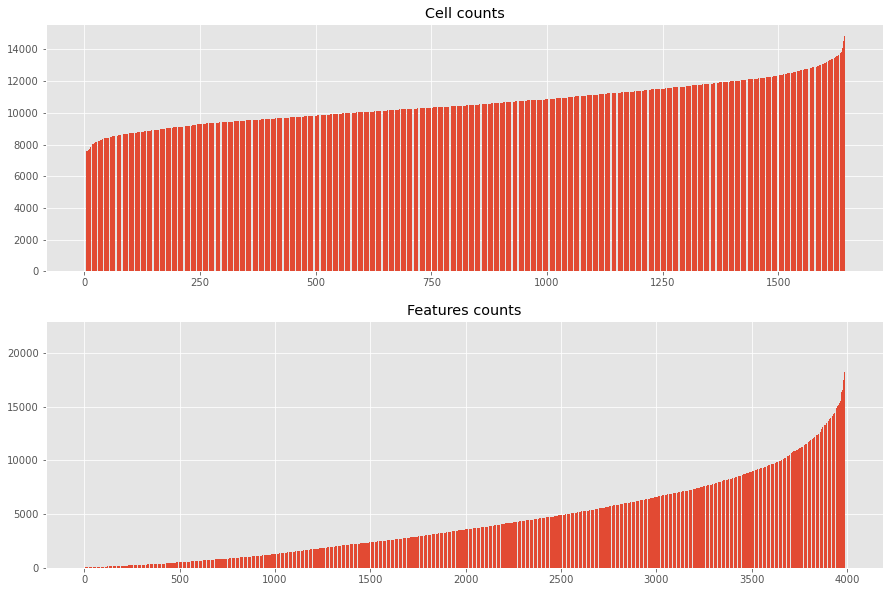

In [43]:
i.getHists()


The data is not zero inflated. It's likely that the data has been filtered.

Let's take a look to cell group label distribution. 

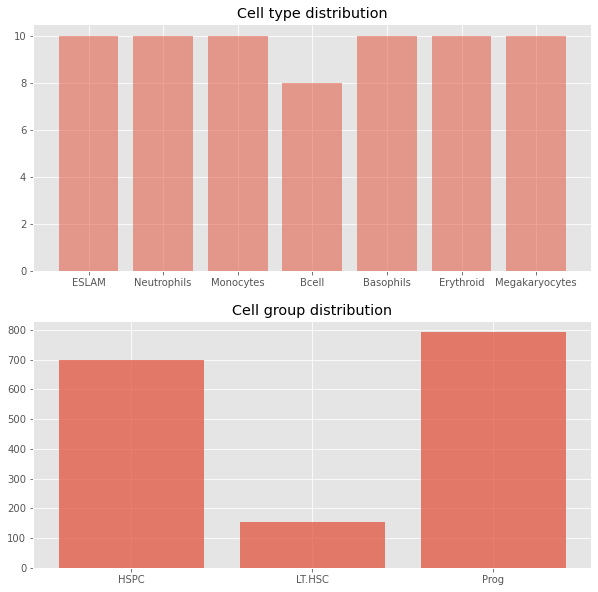

In [44]:
i.getPopulationDensity()


Two kind of labels are available. The first is associated with cell types but appears to be sparse (imcomplete FACS gating). 
Conversly, the major group label (Level of cell differentiation) is complete. 
We will use this label for downstream analysis. 

Let's perform hierarchical clustering prior to other dimensionality reduction methods. 

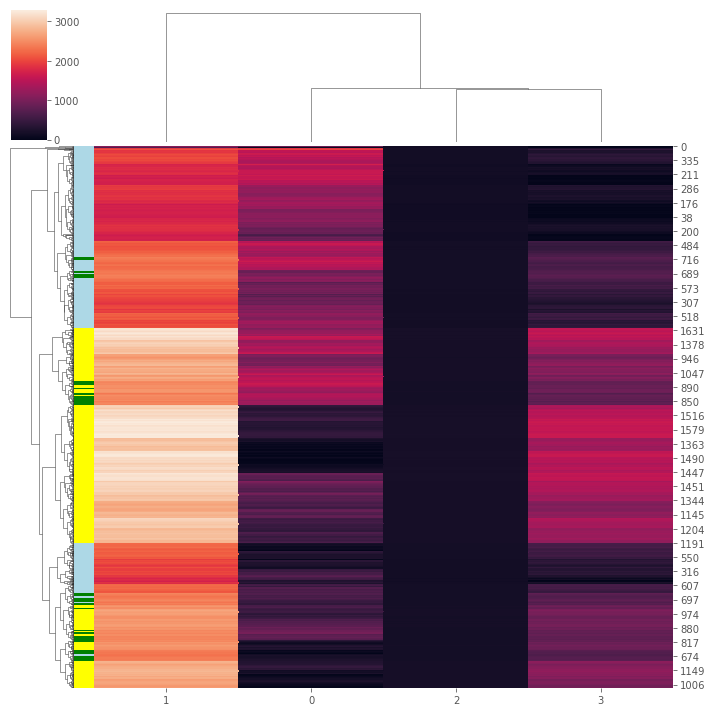

In [45]:
i.getHC()


Some clusters are identifiable. However the the minor label (green) appears to be shared with other ones. 

Let's see how the data looks like using non linear and linear dimensionality reduction methods. 

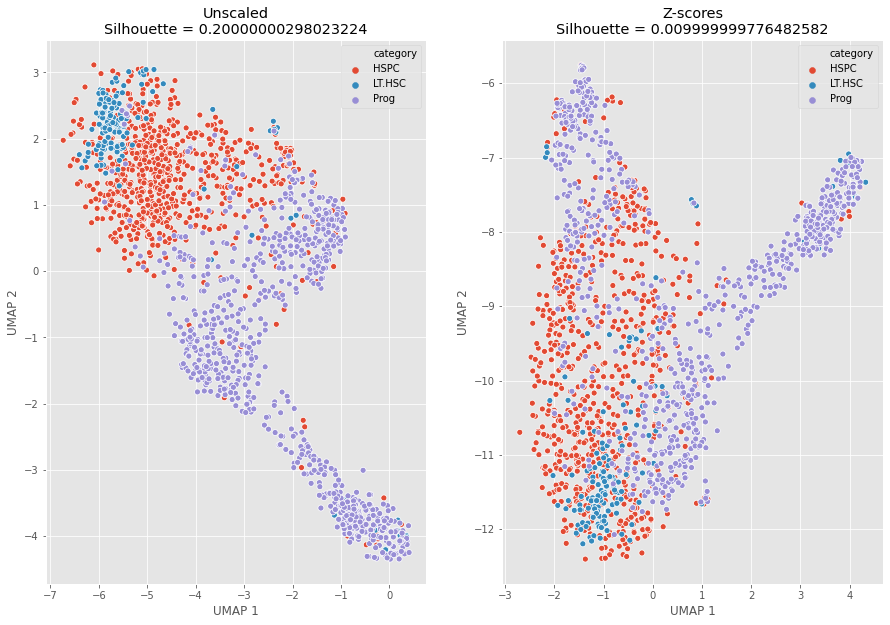

In [46]:
i.scaleData()
i.getUMAP()


Clusters of labels are identifiable in the two UMAP components.<br>
In addition, we can pay attention to the pseudo path formed by cells from less differentiated states to more later ones.<br>
After standardization, the silhouette coefficient metric (Separability) appears to fall. This suggests the existance of non linear interaction between features to define a target cell group.<br>

Let's take a look to how the data looks like in PCA space.

                      0         1
1110032F04Rik  0.004182 -0.001080
1110059E24Rik  0.000030  0.025568
1300017J02Rik  0.013341 -0.004598
1600014C10Rik -0.001196  0.021595
1700017B05Rik  0.025257  0.008323
...                 ...       ...
Zufsp          0.001950  0.000126
Zxdb          -0.001117  0.000573
Zxdc          -0.000251  0.002040
Zyx           -0.036335  0.016833
Zzz3           0.017178  0.005905

[3991 rows x 2 columns] [0.1091818  0.03090783]


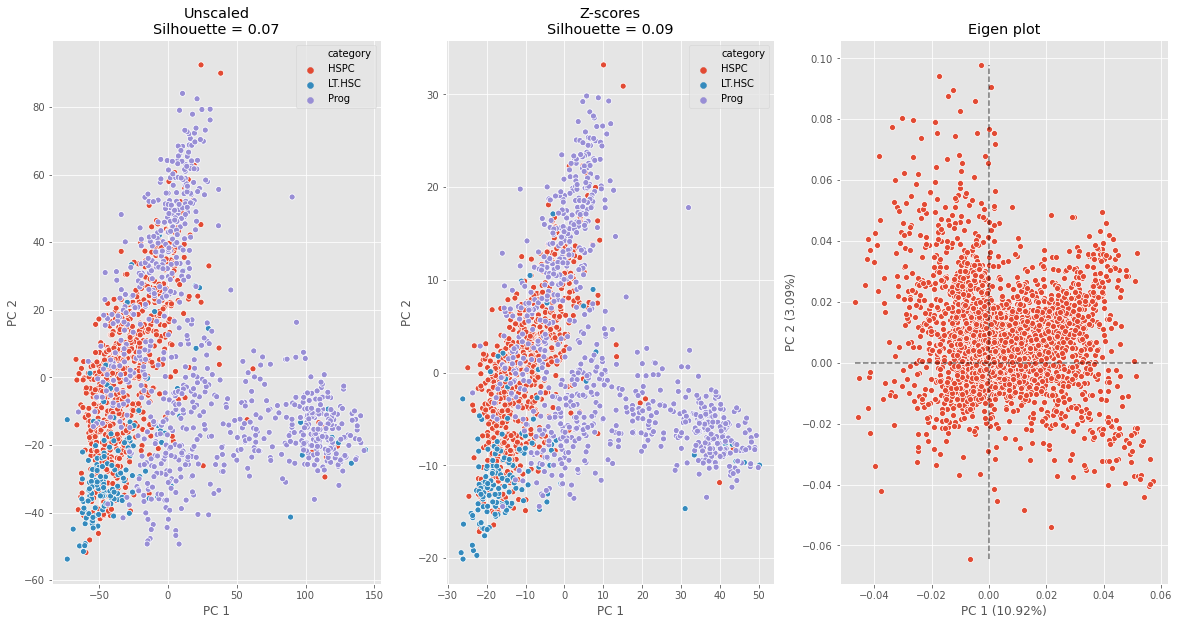

In [40]:
i.getPCA()

Interestingly, we found less separable clusters in PCA space. Comparing it to UMAP, this means that both linear and non linear interactions exists in the feature space. In addition, we could evoke an importance of non linear interaction in cell types definition. 



The next step is about training a deep neural network until convergence, in order to extract features from the first layer. 

The following class allows to: 
- One hot encode the labels 
- Split the dataset into training and testing sets
- Define the model (dynamic instantiation of layers)
- Train it 
- Extract the features

The last method of the class will allows us to compare clustering of extracted features and the original dataset.

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 3991)]            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 3991)              0         
_________________________________________________________________
dense_110 (Dense)            (None, 1996)              7968032   
_________________________________________________________________
dense_111 (Dense)            (None, 998)               1993006   
_________________________________________________________________
dense_112 (Dense)            (None, 499)               498501    
_________________________________________________________________
dense_113 (Dense)            (None, 249)               124500    
_________________________________________________________________
dense_114 (Dense)            (None, 125)             

14/14 [==============================] - 5s 323ms/step - loss: 0.2614 - accuracy: 0.9292 - precision: 0.9306 - recall: 0.9278 - f1: 0.9292 - val_loss: 0.4032 - val_accuracy: 0.8803 - val_precision: 0.8815 - val_recall: 0.8815 - val_f1: 0.8815
Epoch 15/30
 8/14 [================>.............] - ETA: 0s - loss: 0.2218 - accuracy: 0.9281 - precision: 0.9294 - recall: 0.9266 - f1: 0.9280
Epoch 00015: f1 improved from 0.92921 to 0.93935, saving model to Model.hdf5
14/14 [==============================] - 1s 60ms/step - loss: 0.2150 - accuracy: 0.9392 - precision: 0.9406 - recall: 0.9381 - f1: 0.9394 - val_loss: 0.4072 - val_accuracy: 0.8748 - val_precision: 0.8755 - val_recall: 0.8739 - val_f1: 0.8747
Epoch 16/30
11/14 [======================>.......] - ETA: 0s - loss: 0.1894 - accuracy: 0.9489 - precision: 0.9498 - recall: 0.9455 - f1: 0.9476
Epoch 00016: f1 improved from 0.93935 to 0.95175, saving model to Model.hdf5
14/14 [==============================] - 1s 49ms/step - loss: 0.1810 - 

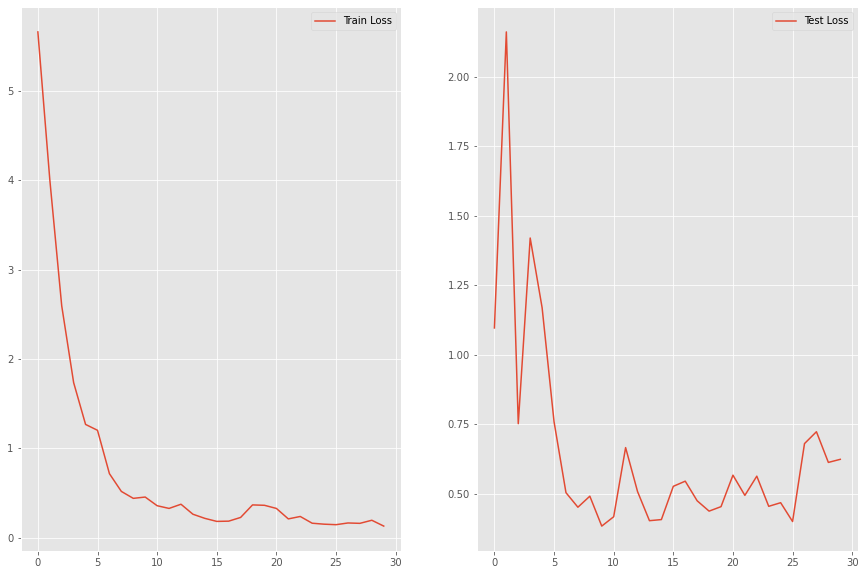

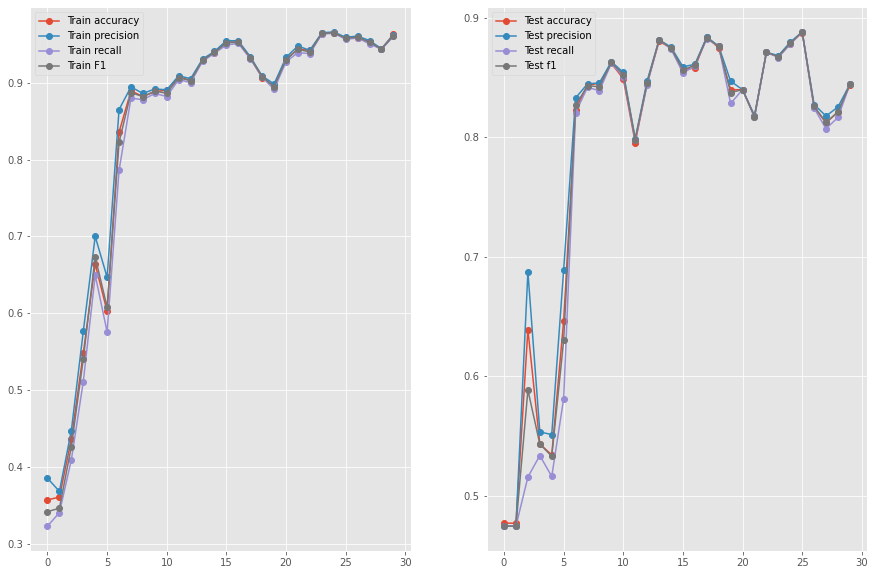

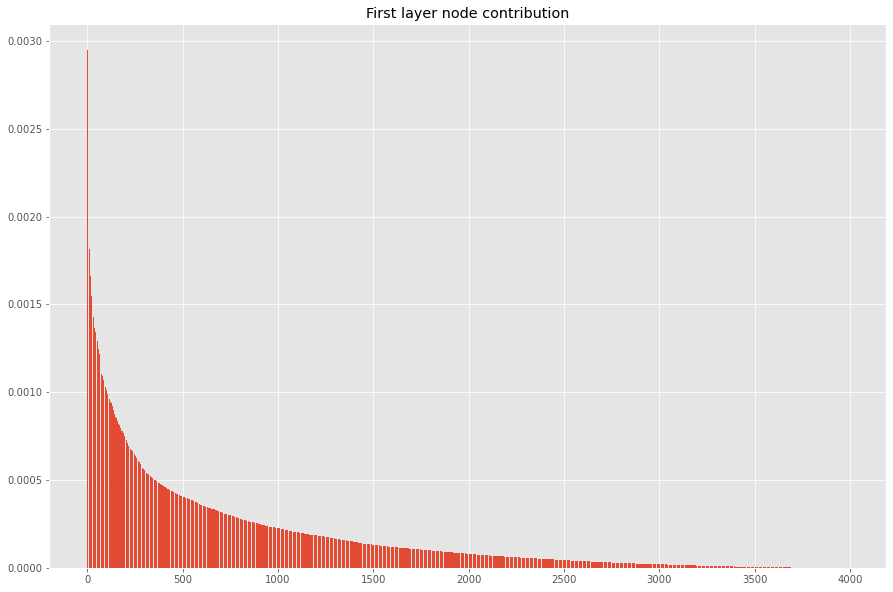

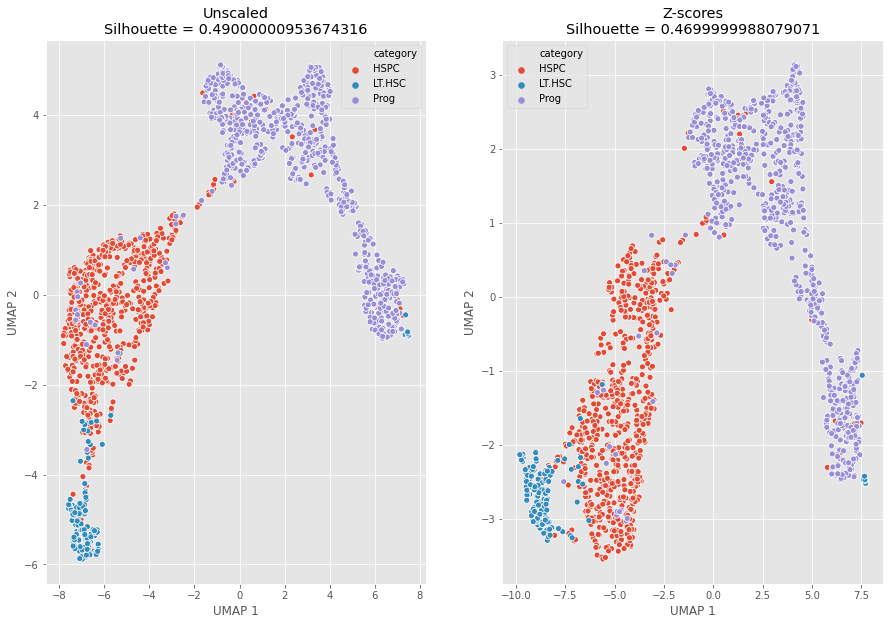

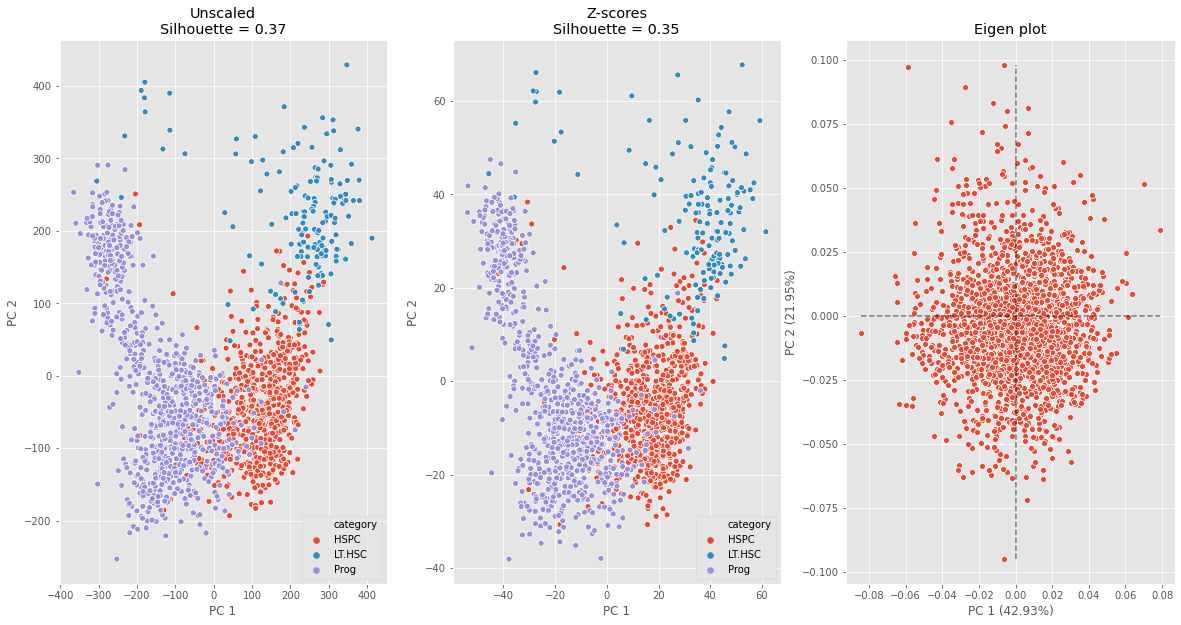

In [35]:
class modelize(): 
    
    def __init__(self,data,data_scaled,labels): 
        self.data = data
        self.X = data
        self.X_scaled = data_scaled
        self.labels = labels 
    
    def OHE(self):
        
        # One hot encoding
        
        self.y = pd.DataFrame([[1 if i==j else 0 for i in self.labels["category"]] 
                             for j in np.unique(self.labels["category"]) ],
                            index=np.unique(self.labels["category"])).T
        
    def splitDataset(self):
        
        # Split the dataset (30%)
        
        self.X_train,self.X_test,self.y_train,self.y_test =  train_test_split(
        self.X, self.y, test_size=0.33,random_state=42)
        
        # Store class weights
        
        self.weights = collections.Counter(self.labels["category"])
        _max = max([self.weights[i] for i in self.weights])
        self.weights = {idx:_max/self.weights[i] for idx,i in enumerate(self.weights)}
             
    
    def setModel(self): 
        
        # Layers sizes = 2000 1000 500 250 125 75 25 5 3
        sizes = [round(self.X.shape[1]/2**x) for x in range(1,11)]
        if sizes[-1]<self.y.shape[1]:
            sizes.pop(-1)
            sizes.append(self.y.shape[1])
        else:
            sizes.append(self.y.shape[1])
            
        # Set the input
        inputs = Input(shape=(self.X.shape[1],))
        drop = Dropout(0.5)
        # Dynamically construct the neural net
        curr = drop(inputs)
        for idx,i in enumerate(sizes):
            if i!=sizes[-1]:
                varname = "L{}".format(idx+1)
                globals()[varname] = Dense(i,activation=tf.keras.layers.LeakyReLU(alpha=0.3))
                curr = globals()[varname](curr)
            else:
                varname = "out"
                globals()[varname] = Dense(i,activation="softmax")(curr)
        
        # Instantiate the model
        self.model = Model(inputs,out)
        print(self.model.summary())
        
        def precision(y_true,y_pred): 
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision 
        
        def recall(y_true,y_pred):
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall
        
        def f1(y_true, y_pred): #taken from old keras source code
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            recall = true_positives / (possible_positives + K.epsilon())
            f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
            return f1_val
            
        # Compile with above metrics
        metrics = ["accuracy",precision,recall,f1]
        self.model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=metrics)
    
    def trainModel(self,epochs=30,batch_size=80): 
        
        # Set checkpoint modalities
        self.filepath = "Model.hdf5"
        checkpoint = ModelCheckpoint(self.filepath, monitor='f1', verbose=1, 
                                         save_best_only=True, mode='max')
        
        # Train the model
        self.history = self.model.fit(self.X_train,self.y_train,epochs=epochs,batch_size=batch_size,verbose=1,
                          callbacks=[checkpoint],validation_data=(self.X_test,self.y_test),class_weight=self.weights)
        
        # Plot losses
        f = plt.figure(figsize=(15,10))
        ax = f.add_subplot(121)
        ax1 = f.add_subplot(122)
        ax.plot([i for i in range(len(self.history.history["loss"]))],self.history.history["loss"],label="Train Loss")
        ax1.plot([i for i in range(len(self.history.history["val_loss"]))],self.history.history["val_loss"],label="Test Loss")
        ax.legend()
        ax1.legend()
        plt.show()
        
        # Plot metrics
        f = plt.figure(figsize=(15,10))
        ax = f.add_subplot(121)
        ax1 = f.add_subplot(122)
        
        # Training
        ax.plot([i for i in range(len(self.history.history["accuracy"]))],self.history.history["accuracy"],label="Train accuracy",marker="o")
        ax.plot([i for i in range(len(self.history.history["precision"]))],self.history.history["precision"],label="Train precision",marker="o")
        ax.plot([i for i in range(len(self.history.history["recall"]))],self.history.history["recall"],label="Train recall",marker="o")
        ax.plot([i for i in range(len(self.history.history["f1"]))],self.history.history["f1"],label="Train F1 ",marker="o")
        
        # Testing
        ax1.plot([i for i in range(len(self.history.history["val_accuracy"]))],self.history.history["val_accuracy"],label="Test accuracy",marker="o")
        ax1.plot([i for i in range(len(self.history.history["val_precision"]))],self.history.history["val_precision"],label="Test precision",marker="o")
        ax1.plot([i for i in range(len(self.history.history["val_recall"]))],self.history.history["val_recall"],label="Test recall",marker="o")
        ax1.plot([i for i in range(len(self.history.history["val_f1"]))],self.history.history["val_f1"],label="Test f1 ",marker="o")
        
        # Legends
        ax.legend()
        ax1.legend()
        plt.show()
    
    def getWeights(self):
        self.model.load_weights(self.filepath)
        weights = np.array(self.model.get_weights()[0])
        t_stat = [(np.mean(i)**2)/np.std(i) for i in weights]
        pos = np.arange(len(t_stat))
        name = ["G{}".format(i) for i in pos]
        pack = [i for i in zip(t_stat,pos,name)]
        pack = sorted(pack,key = lambda x:x[0])[::-1]
        f = plt.figure(figsize=(15,10))
        ax = f.add_subplot(111)
        ax.bar(pos,[i[0] for i in pack])
        ax.xticks = [i[1] for i in pack]
        ax.xticklabels = [i[2] for i in pack]
        ax.set_title("First layer node contribution")
        plt.show()
        
        # DATA X WEIGHTS
        self.data = np.dot(self.data,weights)
        
        # + BIAS
        bias = np.repeat(m.model.get_weights()[1],self.data.shape[0]).reshape(self.data.shape[0],m.model.get_weights()[1].shape[0])
        self.data+=bias
    
    def scaleData(self): 
        
        self.X = self.data.copy()
        sc = StandardScaler()
        self.X_scaled = sc.fit_transform(self.X)
        self.X,self.X_scaled = pd.DataFrame(self.X), pd.DataFrame(self.X_scaled)
        
    def getUMAP(self):
        
        raw_components = pd.DataFrame(umap.UMAP().fit_transform(self.X))
        scaled_components = pd.DataFrame(umap.UMAP().fit_transform(self.X_scaled))
        
        f = plt.figure(figsize=(15,10))
        ax,ax1 = f.add_subplot(121),f.add_subplot(122)
        sns.scatterplot(x = raw_components[0], y = raw_components[1],hue=self.labels["category"],ax=ax)
        sns.scatterplot(x = scaled_components[0], y = scaled_components[1],hue=self.labels["category"],ax=ax1)
        silhouette_raw = silhouette_score(raw_components, self.labels["category"])
        silhouette_scaled = silhouette_score(scaled_components, self.labels["category"])
        
        ax.set_title("Unscaled\nSilhouette = {}".format(round(silhouette_raw,2)))
        ax1.set_title("Z-scores\nSilhouette = {}".format(round(silhouette_scaled,2)))
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")
        ax1.set_xlabel("UMAP 1")
        ax1.set_ylabel("UMAP 2")
        plt.show()

    def getPCA(self): 
        
        pca = PCA(n_components=2)
        
        raw_components = pd.DataFrame(pca.fit_transform(self.X))
        raw_eigen,raw_xv = pd.DataFrame(pca.components_,columns=self.X.columns).T, pca.explained_variance_ratio_

        
        scaled_components = pd.DataFrame(pca.fit_transform(self.X_scaled))
        f = plt.figure(figsize=(20,10))
        ax,ax1,ax2 = f.add_subplot(131),f.add_subplot(132), f.add_subplot(133)
        sns.scatterplot(x = raw_components[0], y = raw_components[1],hue=self.labels["category"],ax=ax)
        sns.scatterplot(x = scaled_components[0], y = scaled_components[1],hue=self.labels["category"],ax=ax1)
        sns.scatterplot(x = raw_eigen[0], y = raw_eigen[1],ax=ax2)
        silhouette_raw = silhouette_score(raw_components, self.labels["category"])
        silhouette_scaled = silhouette_score(scaled_components, self.labels["category"])
        ax.set_title("Unscaled\nSilhouette = {}".format(round(silhouette_raw,2)))
        ax1.set_title("Z-scores\nSilhouette = {}".format(round(silhouette_scaled,2)))
        ax.set_xlabel("PC 1")
        ax.set_ylabel("PC 2")
        ax1.set_xlabel("PC 1")
        ax1.set_ylabel("PC 2")
        ax2.set_xlabel("PC 1 ({}%)".format(round(raw_xv[0]*100,2)))
        ax2.set_ylabel("PC 2 ({}%)".format(round(raw_xv[1]*100,2)))
        ax2.hlines(xmin=min(raw_eigen[0]),xmax=max(raw_eigen[0]),y=0,ls="dashed",alpha=0.5)
        ax2.vlines(ymin=min(raw_eigen[1]),ymax=max(raw_eigen[1]),x=0,ls="dashed",alpha=0.5)
        ax2.set_title("Eigen plot")
        
        
        
        
        
        
        
m = modelize(i.X,i.X_scaled,i.labels)
m.OHE()
m.splitDataset()
m.setModel()
m.trainModel()
m.getWeights()
m.scaleData()
m.getUMAP()
m.getPCA()


The metrics indicates that convergence was full and efficient (near to 100 % F1).
When looking to UMAP plots, the separability appears to have been improved by 5. 
We can appreciate the differentiation path showing more diverging states (could lead to cancer for example). 

In PCA space, we improve the separability by more than 3. The clusters are clearly distinguishable and the eigen plot appears to be less fuzzy but directed. 

Finally, we could have continued the study by computing correlation between extracted features and original ones. 
We could also have performed data integration using other methods. 


Thanks for your attention ! 